In [88]:
import numpy as np
import math
import time

def CIM_CAC_CPU(T_time, J, batch_size=1, time_step=0.05, r=None, alpha=3.0, beta=0.25, gamma=0.00011, delta=10, mu=1, rho=3, tau=1000, noise=0, H0=None, stop_when_solved=False, num_sol=10, custom_fb_schedule=None, custom_pump_schedule=None, cac_nonlinearity=np.tanh):
    """CIM solver with chaotic amplitude control; no external h field, adapted for CPU with NumPy arrays."""

    # Compute instance sizes
    N = J.shape[1]
    if r is None:
        r = 0.8 - (N / 220) ** 2

    # Initialize data arrays
    xi = np.zeros(batch_size)
    t_c = np.zeros(batch_size)
    H = np.zeros(batch_size)
    spin_amplitude_trajectory = np.zeros((batch_size, N, T_time))
    error_var_data = np.zeros((batch_size, N, T_time))
    energy_plot_data = np.zeros((batch_size, T_time))
    t_opt = np.zeros(batch_size)

    # Initialize Spin-Amplitude Vectors and Auxiliary Variables
    x = 0.001 * np.random.rand(batch_size, N) - 0.0005
    error_var = np.ones((batch_size, N))
    effective_tau = tau / time_step

    # Configure ramp schedules
    if custom_fb_schedule is None:
        beta = np.ones(T_time) * beta
    else:
        beta = custom_fb_schedule(np.arange(0, T_time))

    if custom_pump_schedule is None:
        r = np.ones(T_time) * r
    else:
        r = custom_pump_schedule(np.arange(0, T_time))

    # Compute initial Ising energy and spin states
    sig = 2 * (x > 0) - 1
    H = -0.5 * np.sum(sig * (sig @ J), axis=1)

    H_opt = H.copy()
    sig_opt = sig.copy()
    a = alpha * np.ones(batch_size)

    # Simulate Time-Evolution of Spin Amplitudes
    for t in range(T_time):
        x_ = x.copy()
        spin_amplitude_trajectory[:, :, t] = x_
        error_var_data[:, :, t] = error_var
        sig = 2 * (x > 0) - 1
        H = -0.5 * np.sum(sig * (sig @ J), axis=1)
        
        # Euler step for equations of motion of spin amplitudes
        x_squared = x ** 2
        MVM = x @ J
        x += time_step * (x * ((r[t] - 1) - mu * x_squared))
        x += time_step * beta[t] * (MVM * error_var)
        x += beta[t] * noise * (np.random.rand(batch_size, N) - 0.5)

        # Save current Ising energy
        energy_plot_data[:, t] = H

        # Euler step for equations of motion of error variables
        delta_e = -xi[:, None] * (x_ ** 2 - a[:, None]) * error_var
        error_var += delta_e * time_step

        # Normalize auxiliary error variables
        error_var[error_var > 32] = 32

        # Modulate target amplitude, error variable rate of change parameters depending on Ising energy
        xi += gamma * time_step
        dH = H - H_opt
        a = alpha + rho * cac_nonlinearity(delta * dH)

        # Update ramp schedules and minimum Ising energy
        t_c[t_c < t - effective_tau] = t
        xi[t_c < t - effective_tau] = 0
        t_opt[H < H_opt] = t
        t_c[H < H_opt] = t
        H_opt = np.minimum(H_opt, H)

    # Parse and Return Solutions
    spin_plot_data = 2 * (spin_amplitude_trajectory > 0) - 1

    for k in range(batch_size):
        sig_opt[k, :] = spin_plot_data[k, :, int(t_opt[k])]

    return sig_opt, spin_amplitude_trajectory, T_time, energy_plot_data, error_var_data


In [75]:
Time = 1000
J = - np.load('MC50_N=10_2.npz')
solve = CIM_CAC_CPU(Time, J)
spin_config = solve[0]
x_trajectory = solve[1]
T_time = solve[2]
ground_state = solve[3]
error_var = solve[4]

print('spin configuration:', spin_config)
print('spin amplitude trajectory:', x_trajectory.shape)
print('time:', T_time)
print('ground state:', np.min(ground_state))
print('max error variance:', np.max(error_var))

spin configuration: [[-1 -1  1  1 -1  1  1 -1  1  1]]
spin amplitude trajectory: (1, 10, 1000)
time: 1000
ground state: -9.0
max error variance: 1.5073964021461996


# G1 set on CAC

In [123]:
from CAC import *

Time = 1000
file_path = 'G1.txt'

edges = []

with open(file_path, 'r') as file:
    next(file)  # Skip the first row
    for line in file:
        node1, node2, weight = map(int, line.split())  # Convert strings to integers
        edges.append((node1 - 1, node2 - 1, weight))  # Adjust for 0-based indexing

# Determine the number of nodes
num_nodes = max(max(edge[0], edge[1]) for edge in edges) + 1

# Initialize the J matrix with zeros
J_matrix = np.zeros((num_nodes, num_nodes))

# Populate the J matrix based on the edges
for node1, node2, weight in edges:
    J_matrix[node1, node2] = weight
    J_matrix[node2, node1] = weight  # For undirected graphs

# Convert interaction strengths to negative values
J_matrix = -J_matrix

solve = CIM_CAC_GPU(Time, J_matrix)
spin_config = solve[0]
x_trajectory = solve[1]
T_time = solve[2]
ground_state = solve[3]
error_var = solve[4]

# print('spin configuration:', spin_config)
print('ground state:', np.min(ground_state))

ground state: -3492.0


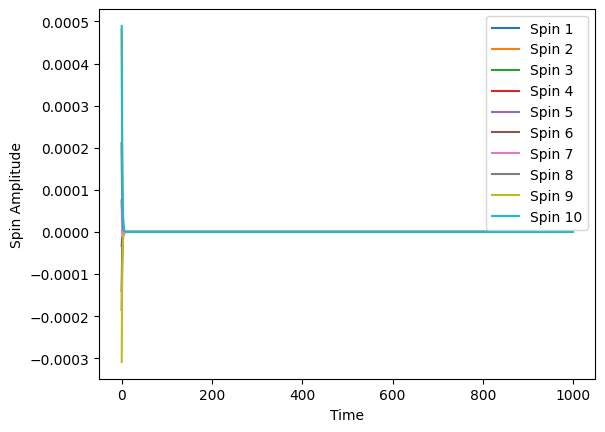

In [124]:
for spin_index in range(10):
    plt.plot(np.arange(T_time+1), x_trajectory[0, spin_index, :], label=f'Spin {spin_index + 1}')
    plt.xlabel('Time')
    plt.ylabel('Spin Amplitude')
    plt.legend()

plt.show()

# G1 set on AHC

In [125]:
from AHC import *

Time = 100
J = - np.load('MC50_N=10_2.npz')
solve = CIM_AHC_GPU(Time, J)
spin_config = solve[0]
ground_state = solve[3]

print('spin configuration:', spin_config)   
print('ground state:', np.min(ground_state))

J = J_matrix
solve = CIM_AHC_GPU(Time, J)
spin_config = solve[0]
ground_state = solve[3]

# print('spin configuration:', spin_config)   
print('ground state:', np.min(ground_state))

spin configuration: [[-1.  1. -1.  1.  1. -1.  1. -1. -1. -1.]]
ground state: -9.0
ground state: -3928.0


spin amplitude trajectory: (2000,)
time: 1999


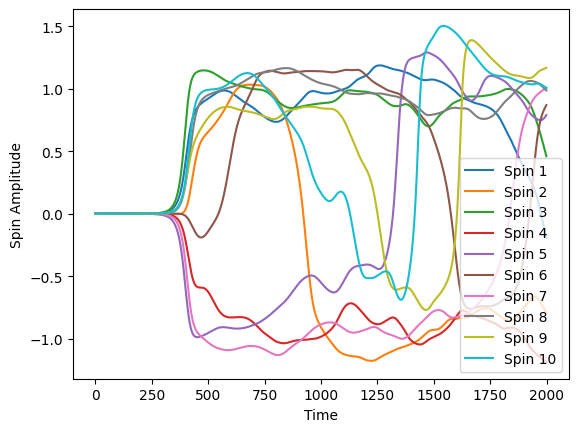

In [126]:
x_trajectory = solve[1]
T_time = solve[2]

print('spin amplitude trajectory:', x_trajectory[0, 0, :].shape)
print('time:', T_time)

for spin_index in range(10):
    plt.plot(np.arange(T_time+1), x_trajectory[0, spin_index, :], label=f'Spin {spin_index + 1}')
    plt.xlabel('Time')
    plt.ylabel('Spin Amplitude')
    plt.legend()

plt.show()

In [83]:
import networkx as nx
# Create a graph of J matrix
Mloop
Optuna



AttributeError: module 'networkx' has no attribute 'from_numpy_matrix'